In [1]:
#import the libraries
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import pandas
import sklearn
import pickle
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import learning_curve   

In [2]:
#load the dataset from the text file with the 'latin-1' encoding
dataset = pd.read_csv("/content/Spam/SMSSpamCollection.txt", sep = '\t',header = None, names = ['Target', 'Input'] , encoding='latin-1')

In [4]:
#sample of the dataset
dataset.head()

,Target,Input
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
#check the counts of the both class [ham, spam]
dataset["Target"].value_counts()

ham     4825
spam     747
Name: Target, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f49604ad0>]],
      dtype=object)

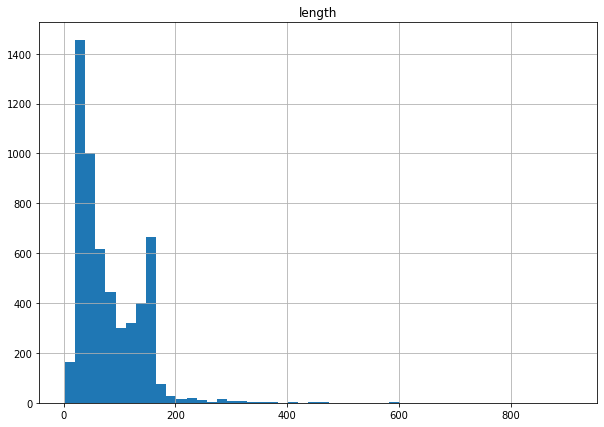

In [ ]:
dataset['length'] = dataset['Input'].map(lambda x: len(x))
dataset.hist(column='length',bins=50, figsize=(10,7))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f4947ee50>,
      dtype=object)

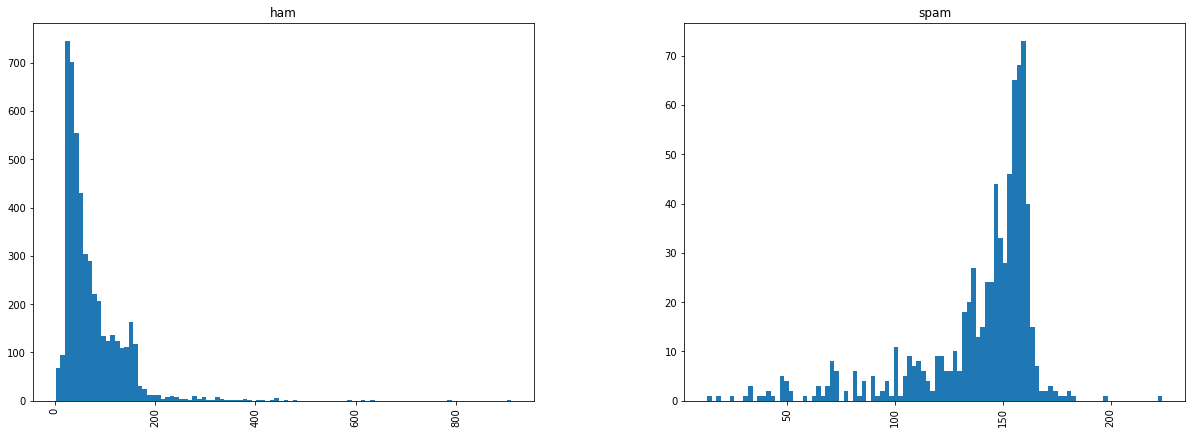

In [ ]:
dataset.hist(column='length', by='Target', bins=100, figsize=(20,7))

In [6]:
#dataset filteration using nltk
import nltk
nltk.download("punkt")
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
ham_words = ''
spam_words = ''

In [11]:
#tokenize the text from the each category to generate the wordcloud
for val in dataset[dataset['Target'] == 'spam'].Input:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        spam_words = spam_words + words + ' '
        
for val in dataset[dataset['Target'] == 'ham'].Input:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        ham_words = ham_words + words + ' '

In [12]:
spam_wordcloud = WordCloud(width=500, height=300).generate(spam_words)
ham_wordcloud = WordCloud(width=500, height=300).generate(ham_words)

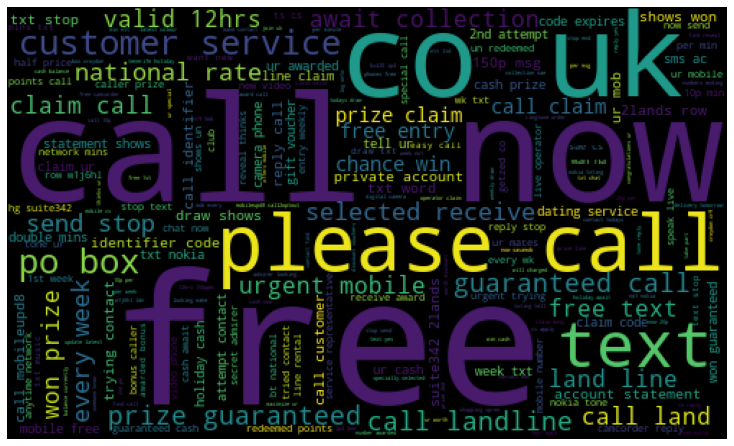

In [13]:
#Spam Word cloud
plt.figure( figsize=(10,8), facecolor='w')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

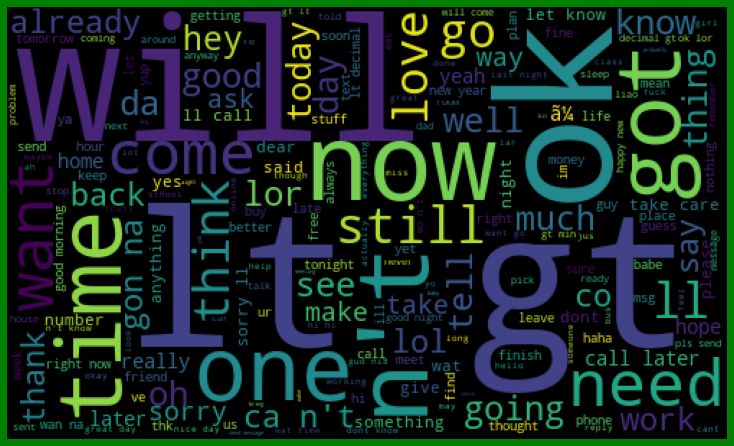

In [14]:
#ham word cloud
plt.figure( figsize=(10,8), facecolor='g')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [15]:
# replace the ham:0 and spam:1
dataset = dataset.replace(['ham','spam'],[0, 1]) 

In [16]:
dataset.head(10)

,Target,Input
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


In [17]:
#remove the stopword from the text
import string
def text_process(text):
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    
    return " ".join(text)

In [19]:
#download the stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
dataset['Input'] = dataset['Input'].apply(text_process)

In [21]:
input = pd.DataFrame(dataset['Input'])
target = pd.DataFrame(dataset['Target'])

In [22]:
## Counting how many times a word appears in the dataset

from collections import Counter

total_counts = Counter()
for i in range(len(input)):
    for word in input.values[i][0].split(" "):
        total_counts[word] += 1

print("Total words in data set: ", len(total_counts))

Total words in data set:  11426


In [23]:
## Sorting in decreasing order (Word with highest frequency appears first)
vocab = sorted(total_counts, key=total_counts.get, reverse=True)
print(vocab[:60])

['u', '2', 'call', 'U', 'get', 'Im', 'ur', '4', 'ltgt', 'know', 'go', 'like', 'dont', 'come', 'got', 'time', 'day', 'want', 'Ill', 'lor', 'Call', 'home', 'send', 'one', 'going', 'need', 'Ok', 'good', 'love', 'back', 'n', 'still', 'text', 'im', 'later', 'see', 'da', 'ok', 'think', 'Ã¼', 'free', 'FREE', 'r', 'today', 'Sorry', 'week', 'phone', 'mobile', 'cant', 'tell', 'take', 'much', 'night', 'way', 'Hey', 'reply', 'work', 'give', 'make', 'new']


In [24]:
#words to vector using tfidfvectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(dataset['Input'])
vectors.shape

(5572, 9459)

In [25]:
features = vectors

In [26]:
#split the dataset for the training and the validation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, dataset['Target'], test_size=0.2, random_state=111, stratify = dataset['Target'])

In [27]:
#check the shape of the training and the testing
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(4457, 9459)
(1115, 9459)
(4457,)
(1115,)


In [28]:
#let's first try the xgboost as it's most popular on the kaggle
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'error'
params['eta'] = 0.02
params['max_depth'] = 10

d_train = xgb.DMatrix(X_train, label=y_train)

watchlist = [(d_train, 'train')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=400, verbose_eval=10)

[0]	train-error:0.03545
Will train until train-error hasn't improved in 400 rounds.
[10]	train-error:0.035225
[20]	train-error:0.032982
[30]	train-error:0.030289
[40]	train-error:0.028719
[50]	train-error:0.027821
[60]	train-error:0.026924
[70]	train-error:0.027148
[80]	train-error:0.025802
[90]	train-error:0.025578
[100]	train-error:0.025578
[110]	train-error:0.02468
[120]	train-error:0.024007
[130]	train-error:0.023783
[140]	train-error:0.023783
[150]	train-error:0.023783
[160]	train-error:0.02311
[170]	train-error:0.022661
[180]	train-error:0.022661
[190]	train-error:0.022437
[200]	train-error:0.021764
[210]	train-error:0.021539
[220]	train-error:0.021539
[230]	train-error:0.020642
[240]	train-error:0.019969
[250]	train-error:0.019295
[260]	train-error:0.019071
[270]	train-error:0.018622
[280]	train-error:0.018398
[290]	train-error:0.018398
[300]	train-error:0.018174
[310]	train-error:0.017949
[320]	train-error:0.017725
[330]	train-error:0.017501
[340]	train-error:0.017501
[350]	tra

In [29]:
#now let's check the accuracy with the confusion matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Predict values for test set
d_test = xgb.DMatrix(X_test)
p_test = bst.predict(d_test)

# Apply function round() to each element in np array
# so predictions are all either 0 or 1.
npround = np.vectorize(round)
p_test_ints = npround(p_test)

# Error rate for test set
accuracy = accuracy_score(y_test, p_test_ints)
print("Test Accuracy: ", accuracy)

confusion_pr=confusion_matrix(y_test, p_test_ints)
confusion_pr

Test Accuracy:  0.9766816143497757


array([[961,   5],
       [ 21, 128]])

In [30]:
#accuracy is pretty good from the above one algorith but let's try it also from the sklearn prebuilt classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [31]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)

In [32]:
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc}

In [33]:
def train(clf, features, targets):    
    clf.fit(features, targets)

def predict(clf, features):
    return (clf.predict(features))

In [34]:
pred_scores_word_vectors = []
for k,v in clfs.items():
    train(v, X_train, y_train)
    pred = predict(v, X_test)
    pred_scores_word_vectors.append((k, [accuracy_score(y_test , pred)]))

In [35]:
predictions = pd.DataFrame.from_dict(dict(pred_scores_word_vectors),orient='index', columns=['Score'])
predictions

,Score
SVC,0.971300
KN,0.933632
NB,0.985650
DT,0.971300
LR,0.953363
RF,0.977578


In [36]:
#from the above table accuracy is best from the Naive Bayes classifier but also check the confusion matrix on the validation dataset 
#so first export the model

In [38]:
#export the model
import joblib
joblib.dump(mnb, 'spam_classfication.pkl')
print ("Best Model (Naive Bayes) Saved")

Best Model (Naive Bayes) Saved


In [39]:
#load the model
best = joblib.load('spam_classfication.pkl')

In [40]:
#prediction on the validation
pred = best.predict(X_test)

In [41]:
#confusion matrix
confusion_pr=confusion_matrix(y_test, pred)
confusion_pr

array([[961,   5],
       [ 11, 138]])

In [ ]:
#from the above result I've decided to pick the NB model for the spam filteration

In [43]:
#let's test it again

test_dataset = pd.DataFrame()

data = {'sample':["Free tones Hope you enjoyed your new content","No. I meant the calculation is the same. That I'll call later"
,"Had your contract mobile 11 Mnths? Latest Motorola Now","WINNER!! You just won a free ticket to Bahamas. Send your Details"]}

test_dataset = pd.DataFrame(data)       




In [44]:
test_dataset

,sample
0,Free tones Hope you enjoyed your new content
1,No. I meant the calculation is the same. That ...
2,Had your contract mobile 11 Mnths? Latest Moto...
3,WINNER!! You just won a free ticket to Bahamas...


In [45]:
#create a dataframe for storing the results with the probability
results = pd.DataFrame(columns = ["input", "prediction", "probability"])

In [75]:
#store the predicted reults and probability in a dataframe
inp = []
predctn = []
prob = []
sample_list = []

sample = test_dataset["sample"]

for i in range(len(test_dataset)):
  sample_list = []
  sample1 = sample[i]
  sample_list.append(sample1)
  integers1 = vectorizer.transform(sample_list)
  p1 = best.predict(integers1)[0]
  prob1 = (mnb.predict_proba(integers1))[0][1]
  if(prob1>=0.7):
    prd = "SPAM"
  else:
    prd = "Not Spam"
  inp.append(sample1)
  predctn.append(prd)
  prob.append(prob1)






results["input"] = inp
results["prediction"]  = predctn
results["probability"] = prob

results

,input,prediction,probability
0,Free tones Hope you enjoyed your new content,SPAM,0.836152
1,No. I meant the calculation is the same. That ...,Not Spam,0.008505
2,Had your contract mobile 11 Mnths? Latest Moto...,SPAM,0.937977
3,WINNER!! You just won a free ticket to Bahamas...,SPAM,0.734554
